# Initial exploration V1.1

After the "inital exploration v1.0", the code was largely refactored. Previously, the specific models (CDNA, DNA and STP) were functions. Now all their specific logic was moved into their own class. Therefore, all the link, variables and states are now contained in separate classes.

In [ ]:
# All the specific model has the same __init__ and __call__ interface. 
# They should all return the results of their transformation but also the seventh convolution of the network
class StatelessCDNA(chainer.Chain):
    def __init__(self, num_masks):
        super(StatelessCDNA, self).__init__(
            enc7 = L.Deconvolution2D(in_channels=64, out_channels=3, ksize=(1,1), stride=1),
            cdna_kerns = L.Linear(in_size=None, out_size=DNA_KERN_SIZE * DNA_KERN_SIZE * num_masks)
        )

        self.num_masks = num_masks
    
    def __call__(self, encs, hiddens, batch_size, prev_image, num_masks, color_channels):
        """
            Learn through StatelessCDNA.
            Args:
                encs: An array of computed transformation
                hiddens: An array of hidden layers
                batch_size: Size of mini batches
                prev_image: The image to transform
                num_masks: Number of masks to apply
                color_channels: Output color channels
            Returns:
                transformed: A list of masks to apply on the previous image
        """
        #...
        return transformed, enc7

class StatelessDNA(chainer.Chain):
    def __init__(self, num_masks):
        #...
        
    def __call__(self, encs, hiddens, batch_size, prev_image, num_masks, color_channels):
        #...
        return transformed, enc7
    
class StatelessSTP(chainer.Chain):
    def __init__(self, num_masks):
        #...
        
    def __call__(self, encs, hiddens, batch_size, prev_image, num_masks, color_channels):
        #...
        return transformed, enc7

The general flow of the transformation executed in the Model class was also refactored. Pratically all the transformation where as follow: LSTM -> Layer Normalization -> LSTM -> Layer Normalization -> Convolution. For the cases where the flow was not exactly the same (e.g: the smear operation for the third convolution), some functions were added to improve the flexibility. Now all the operations are defined inside an array. It's very easy to add, remove and change the order of the operations. It's also very easy to extend the regular operations with custom one.

In [ ]:
# These are defined inside the __init__ constructor of the Model class
def __init__(self, num_masks, is_cdna=True, is_dna=False, is_stp=False, 
             use_state=True, scheduled_sampling_k=-1, num_frame_before_prediction=2, prefix=None):
#...
    # Condition ops callback
    def ops_smear(use_state):
        def ops(args):
            x = args.get("x")
            if use_state:
                state_action = args.get("state_action")
                batch_size = args.get("batch_size")
    
                smear = F.reshape(state_action, (int(batch_size), int(state_action.shape[1]), 1, 1))
                smear = F.tile(smear, (1, 1, int(x.shape[2]), int(x.shape[3])))
                x = F.concat((x, smear), axis=1) # Previously axis=3 but our channel is on axis=1? ok
            return x
        return ops
    
    def ops_skip_connection(enc_idx):
        def ops(args):
            x = args.get("x")
            enc = args.get("encs")[enc_idx]
            # Skip connection (current input + target enc)
            x = F.concat((x, enc), axis=1) # Previously axis=3 but our channel is on axis=1? ok!
            return x
        return ops
    
    def ops_save(name):
        def ops(args):
            x = args.get("x")
            save_map = args.get("map")
            save_map[name] = x
            return x
        return ops
    
    def ops_get(name):
        def ops(args):
            save_map = args.get("map")
            return save_map[name]
        return ops
    
    
    # Create an executable array containing all the transformations
    self.ops = [
        [self.enc0, self.norm_enc0],
        [self.lstm1, self.hidden1, ops_save("hidden1"), self.lstm2, self.hidden2, ops_save("hidden2"), self.enc1],
        [self.lstm3, self.hidden3, ops_save("hidden3"), self.lstm4, self.hidden4, ops_save("hidden4"), self.enc2],
        [ops_smear(use_state), self.enc3],
        [self.lstm5, self.hidden5, ops_save("hidden5"), self.enc4],
        [self.lstm6, self.hidden6, ops_save("hidden6"), ops_skip_connection(1), self.enc5],
        [self.lstm7, self.hidden7, ops_save("hidden7"), ops_skip_connection(0), self.enc6, self.norm_enc6]
    ]

# This loop is used in __call__ to execute the transformation array
def __call__(self, x, iter_num=-1.0):
    # ...
    """ Execute the ops array of transformations """
    # If an ops has a name of "ops" it means it's a custom ops
    encs = []
    maps = {}
    x = prev_image
    for i in xrange(len(self.ops)):
        for j in xrange(len(self.ops[i])):
            op = self.ops[i][j]
            if isinstance(op, types.FunctionType):
                # Only these values are use now in the ops callback
                x = op({
                    "x": x, 
                    "encs": encs, 
                    "map": maps, 
                    "state_action": state_action, 
                    "batch_size": batch_size
                })
            else:
                x = op(x)
        # ReLU at the end of each transformation
        x = F.relu(x)
        # At the end of j iteration = completed a enc transformation
        encs.append(x)
    
    # Finally this calls the specific transformations (CDNA, DNA or STP)
    hiddens = [
        maps.get("hidden1"), maps.get("hidden2"), maps.get("hidden3"), maps.get("hidden4"),
        maps.get("hidden5"), maps.get("hidden6"), maps.get("hidden7")
    ]
    enc0, enc1, enc2, enc3, enc4, enc5, enc6 = encs
    hidden1, hidden2, hidden3, hidden4, hidden5, hidden6, hidden7 = hiddens

    """ Specific model transformations """
    transformed, enc7 = self.model(
        encs, hiddens,
        batch_size, prev_image, self.num_masks, int(color_channels)
    )

## Abstract

Before doing any specific transformations, these transformations are applied:

In [1]:
self.ops = [
    [self.enc0, self.norm_enc0],
    [self.lstm1, self.hidden1, ops_save("hidden1"), self.lstm2, self.hidden2, ops_save("hidden2"), self.enc1],
    [self.lstm3, self.hidden3, ops_save("hidden3"), self.lstm4, self.hidden4, ops_save("hidden4"), self.enc2],
    [ops_smear(use_state), self.enc3],
    [self.lstm5, self.hidden5, ops_save("hidden5"), self.enc4],
    [self.lstm6, self.hidden6, ops_save("hidden6"), ops_skip_connection(1), self.enc5],
    [self.lstm7, self.hidden7, ops_save("hidden7"), ops_skip_connection(0), self.enc6, self.norm_enc6]
]

# enc0-enc3 = Convolution2D
# enc4-enc6 = Deconvolution2D
# hidden* = LayerNormalisation
# lstm* = Normal LSTM cell with forget bias = 1 for forget gate

NameError: name 'self' is not defined

The results of these transformations (no CDNA, DNA and STP) can be visualized like that:
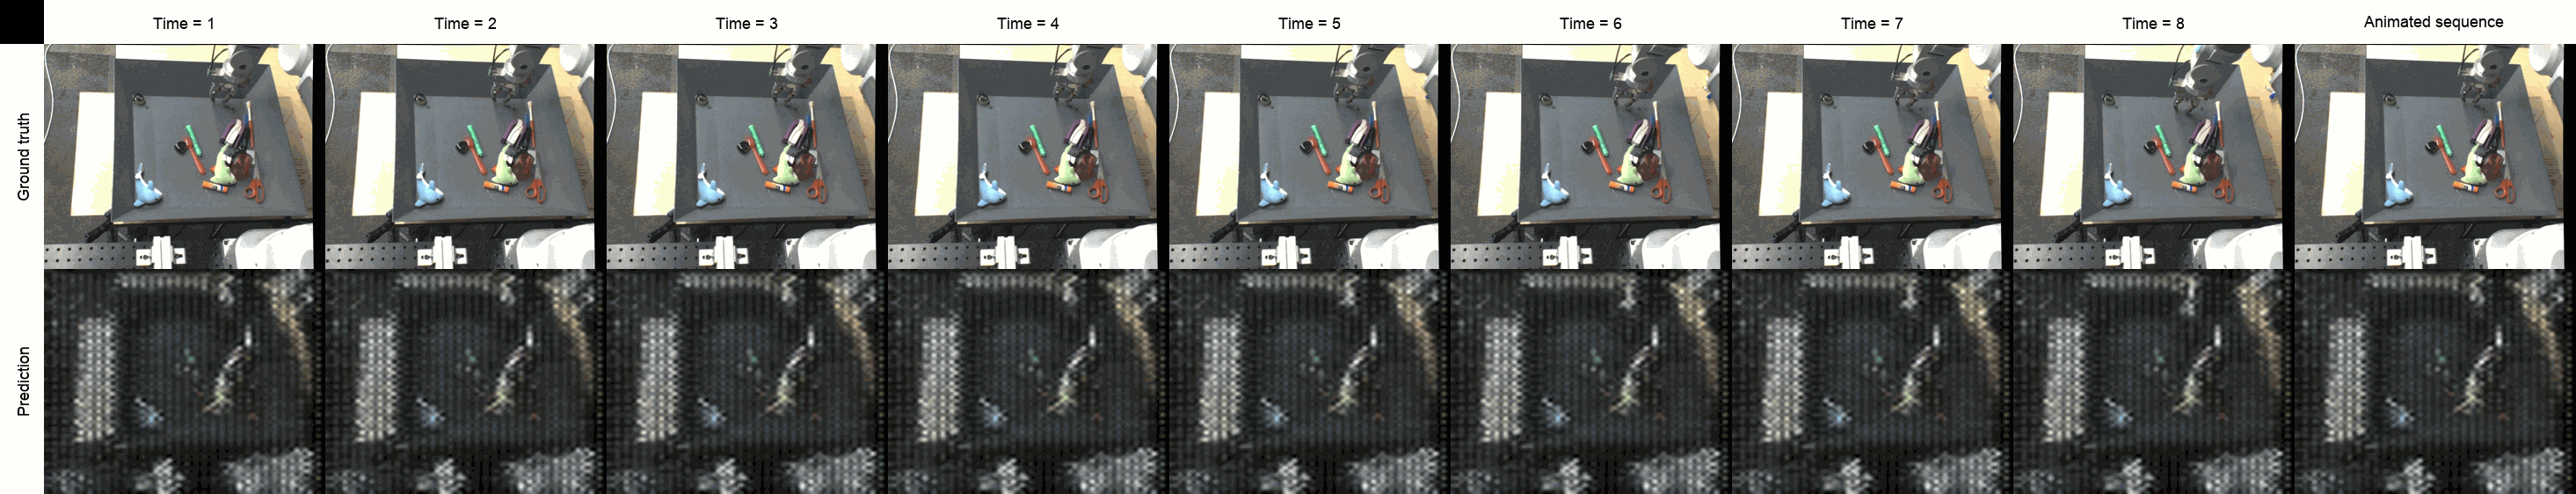

The layer activation of all the convolution and de-convolution:
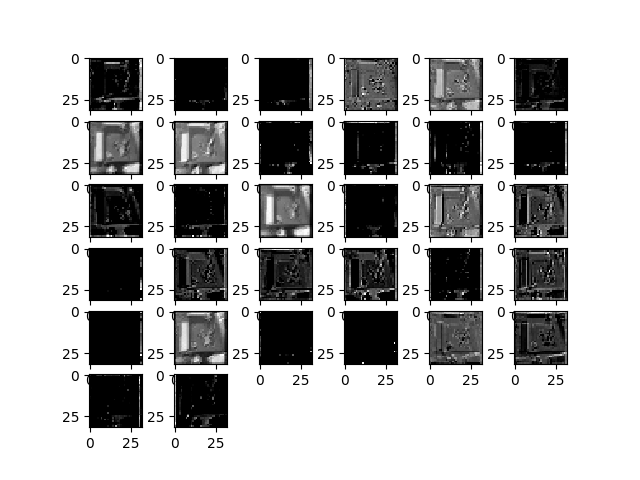
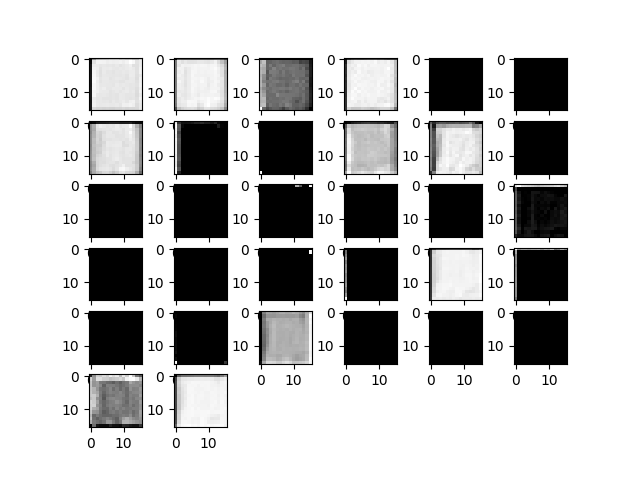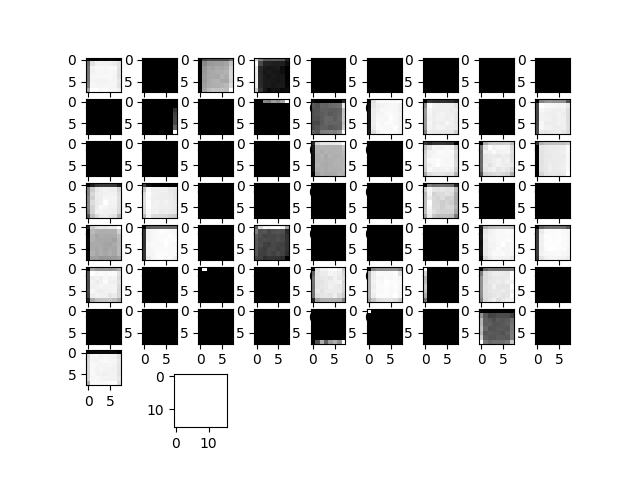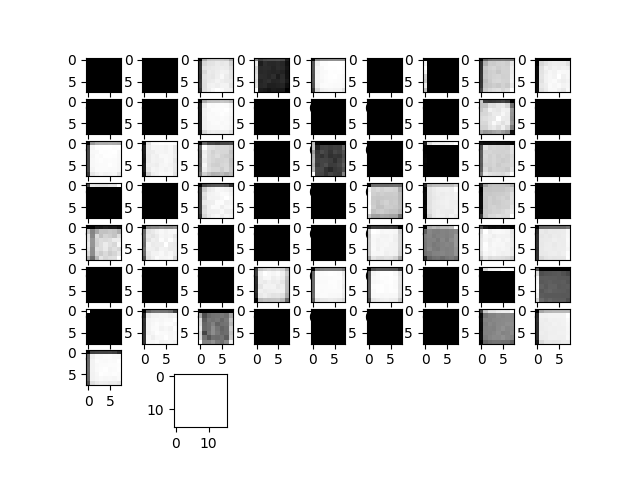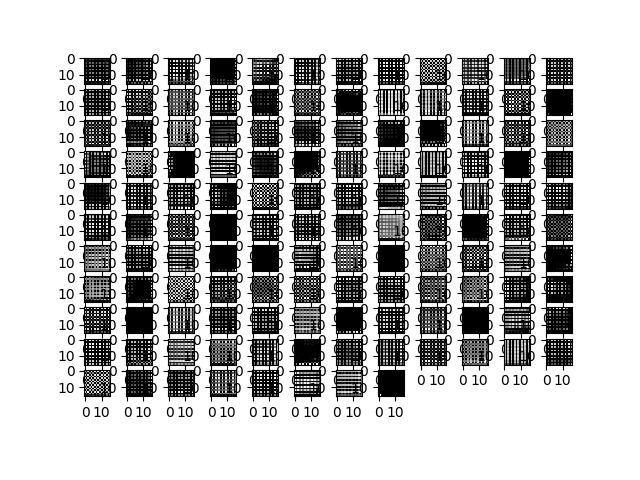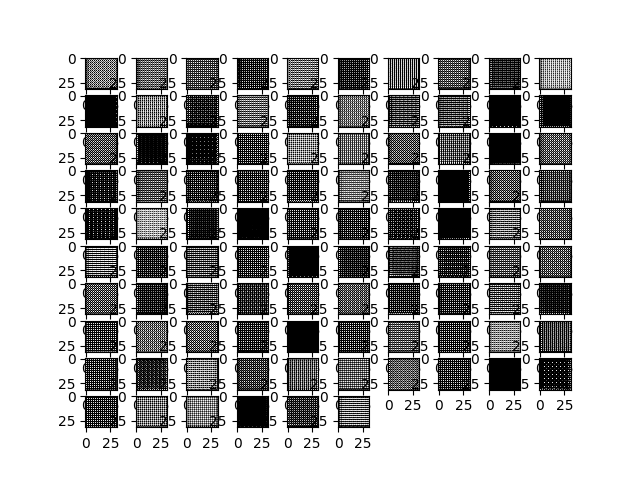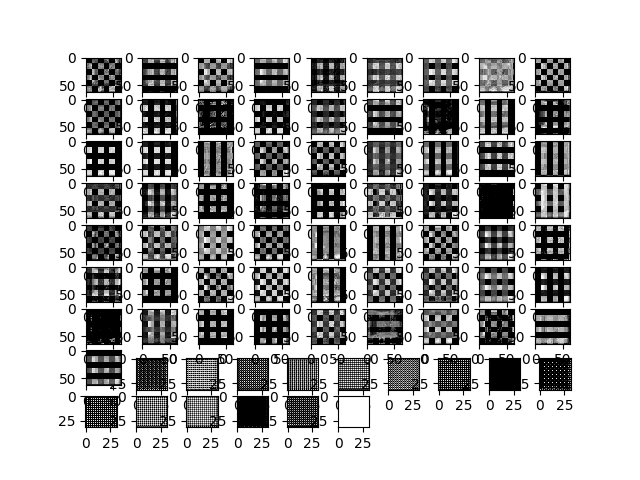